# To test the output of the GUI

# num_qubits = 1, dim_x = 1, dim_alpha = 1

## Part 1 Output

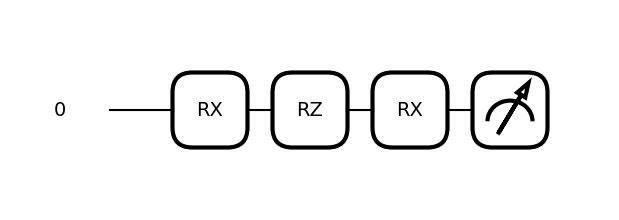

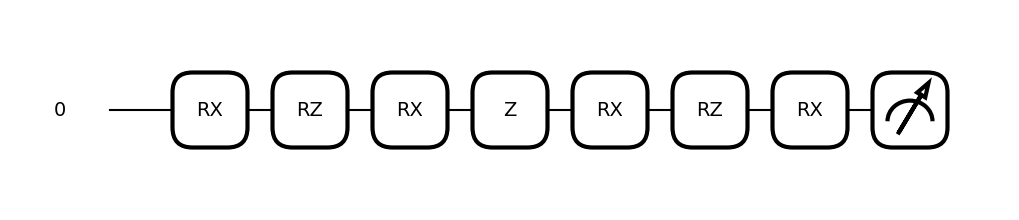

In [1]:
import pennylane as qml
import numpy as np

dim_x = 1
dim_alpha = 1
observable_terms = ['Z0']

def build_P(observable_terms):
    import pennylane as qml
    P = None
    for term in observable_terms:
        pieces = term.replace('+',' ').split()
        local = None
        for p in pieces:
            op = p[0].upper()
            idx = int(p[1:])
            t = getattr(qml, f'Pauli{op}')(idx)
            local = t if local is None else local @ t
        P = local if P is None else P + local
    return P if P is not None else qml.PauliZ(0)

dev = qml.device('default.qubit', wires=1)

@qml.qnode(dev)
def U(x, α):
    qml.RX(np.pi * x[0], wires=0)
    qml.RZ(np.pi * α[0], wires=0)
    qml.RX(np.pi * x[0], wires=0)
    return qml.state()

@qml.qnode(dev)
def UPU(x, α):
    qml.RX(np.pi * x[0], wires=0)
    qml.RZ(np.pi * α[0], wires=0)
    qml.RX(np.pi * x[0], wires=0)
    P = build_P(observable_terms)
    qml.RX(np.pi * -x[0], wires=0)
    qml.RZ(np.pi * -α[0], wires=0)
    qml.RX(np.pi * -x[0], wires=0)
    return qml.state()

x0 = np.zeros(dim_x)
α0 = np.zeros(dim_alpha)
qml.draw_mpl(U)(x0, α0);
qml.draw_mpl(UPU)(x0, α0);


## Part 2 Output

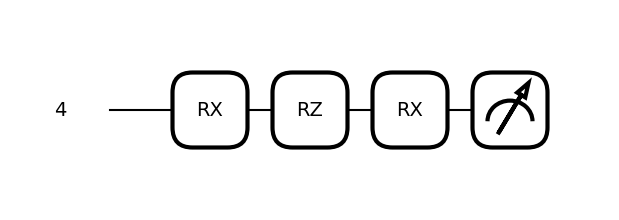

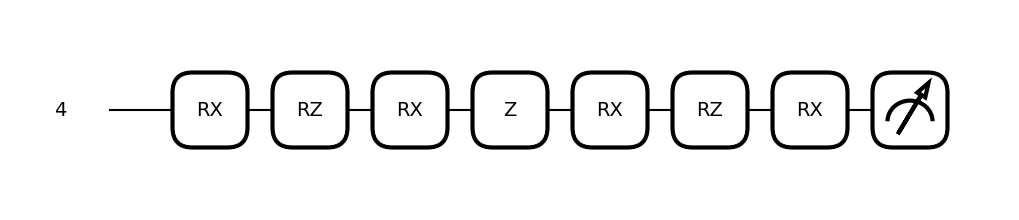

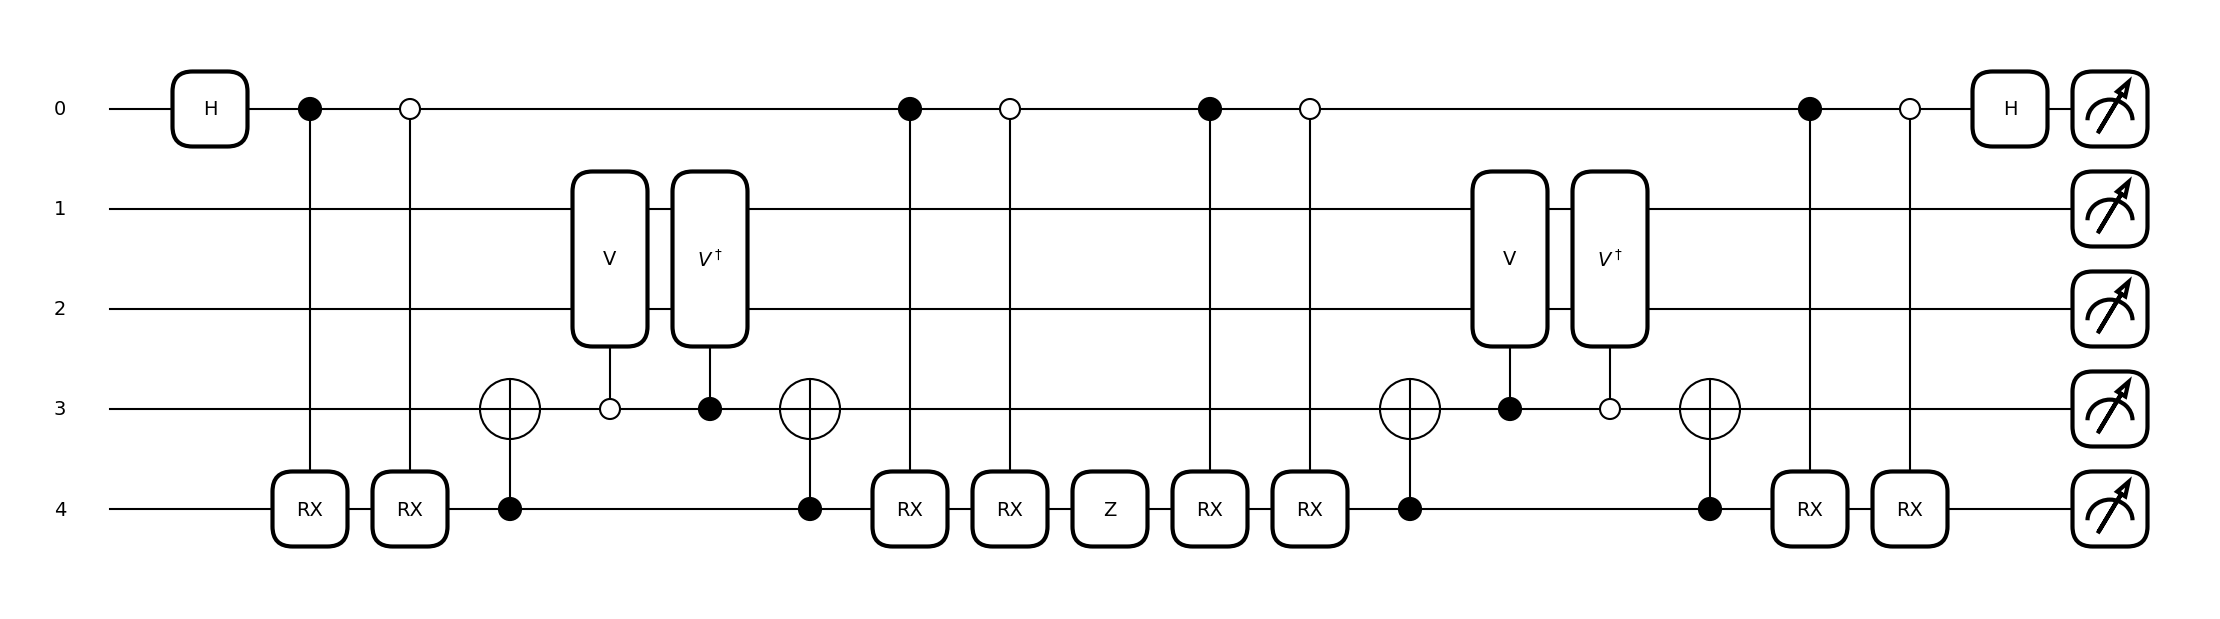

In [2]:
import pennylane as qml
import numpy as np


# Wrapper gates for controlled Adders
class V(qml.operation.Operation):
    def __init__(self, value, wires, mod):
        super().__init__(wires=wires)
        self.value = value
        self.mod = mod


    def decomposition(self):
        # Actual gate: controlled Adder
        return qml.Adder(self.value, x_wires=self.x_wires, mod=self.mod)

# Adjoint version
class Vdagger(V):
    def __name__(self):
        return "V†"

    def decomposition(self):
        return qml.Adder(self.value, x_wires=self.x_wires, mod=self.mod)
Vdagger.__name__ = r"$V^\dagger$"

dim_x=1
dim_alpha=1
observable_terms=['Z0']

# build_P function
def build_P(observable_terms):
    import pennylane as qml
    P = None
    for term in observable_terms:
        pieces = term.replace('+',' ').split()
        local = None
        for p in pieces:
            op = p[0].upper()
            idx = int(p[1:])
            t = getattr(qml, f'Pauli{op}')(idx)
            local = t if local is None else local @ t
        P = local if P is None else P + local
    return P if P is not None else qml.PauliZ(0)

n_kernel=1; freq_register_sizes={0: 2}; n_freq=2
n_anc=1; n_circ=1; n_total=5
kernel_offset=0; freq_offset=1
anc_offset=3; circ_offset=4

dev=qml.device('default.qubit', wires=n_total)

@qml.qnode(dev)
def U(x, α):
    qml.RX(np.pi * x[0], wires=4)
    qml.RZ(np.pi * α[0], wires=4)
    qml.RX(np.pi * x[0], wires=4)
    return qml.state()

@qml.qnode(dev)
def UPU(x, α):
    qml.RX(np.pi * x[0], wires=4)
    qml.RZ(np.pi * α[0], wires=4)
    qml.RX(np.pi * x[0], wires=4)
    # build P on shifted observables
    shifted_terms=[]
    for term in observable_terms:
        parts=term.replace('+',' ').split()
        new_parts=[]
        for p in parts:
            op=p[0].upper()
            idx=int(p[1:])
            new_parts.append(f'{op}{idx+4}')
        shifted_terms.append(' '.join(new_parts))
    P=build_P(shifted_terms)
    # user-provided adjoint (trimmed prefix)
    qml.RX(np.pi * -x[0], wires=4)
    qml.RZ(np.pi * -α[0], wires=4)
    qml.RX(np.pi * -x[0], wires=4)
    return qml.state()

@qml.qnode(dev)
def AuPAu(x, x1, α):
    qml.Hadamard(wires=0)

    qml.ctrl(qml.RX, control=0, control_values=[1])(np.pi * x[0], wires=4)
    qml.ctrl(qml.RX, control=0, control_values=[0])(np.pi * x1[0], wires=4)
    qml.CNOT(wires=(4,3))
    qml.ctrl(V, control = 3, control_values = [0])( value = 1, wires=[1, 2], mod=2**2)
    qml.ctrl(Vdagger, control = 3, control_values = [1])( value = -1, wires=[1, 2], mod=2**2)
    qml.CNOT(wires=(4,3))
    qml.ctrl(qml.RX, control=0, control_values=[1])(np.pi * x[0], wires=4)
    qml.ctrl(qml.RX, control=0, control_values=[0])(np.pi * x1[0], wires=4)

    shifted_terms=[]
    for term in observable_terms:
        parts=term.replace('+',' ').split()
        new_parts=[]
        for p in parts:
            op=p[0].upper()
            idx=int(p[1:])
            new_parts.append(f'{op}{idx+4}')
        shifted_terms.append(' '.join(new_parts))
    P=build_P(shifted_terms)

    # Adjoint – reverse of duplicated U
    qml.ctrl(qml.RX, control=0, control_values=[1])(np.pi * x1[0], wires=4)
    qml.ctrl(qml.RX, control=0, control_values=[0])(np.pi * x[0], wires=4)
    qml.CNOT(wires=(4,3))
    qml.ctrl(V, control = 3, control_values = [1])( value = 1, wires=[1, 2], mod=2**2)
    qml.ctrl(Vdagger, control = 3, control_values = [0])( value = -1, wires=[1, 2], mod=2**2)
    qml.CNOT(wires=(4,3))
    qml.ctrl(qml.RX, control=0, control_values=[1])(np.pi * x1[0], wires=4)
    qml.ctrl(qml.RX, control=0, control_values=[0])(np.pi * x[0], wires=4)
    qml.Hadamard(wires=0)
    return qml.state()

# Example caller
x0=np.zeros(dim_x); x1=np.copy(x0); α0=np.zeros(dim_alpha)
qml.draw_mpl(U)(x0, α0); qml.draw_mpl(UPU)(x0, α0); qml.draw_mpl(AuPAu)(x0, x1, α0);